In [1]:
def trayectoria(t0, tf, q0, qf, n=100):
    
    from numpy import linspace
    
    v = (3/2)*(qf - q0)/tf
    tb = (q0 - qf + v*tf - 2*v*t0)/v
    a = v/(tb - t0)
    ts = linspace(t0, tf, n)
    
    qs = []
    q̇s = []
    q̈s = []
    
    for t in ts:
        if t <= tb:
            qs.append(q0 + a/2*(t - t0)**2)
            q̇s.append(a*(t - t0))
            q̈s.append(a)
        else:
            if t <= tf - tb:
                qs.append(q0 + a/2*(tb - t0)**2 + v*(t - tb))
                q̇s.append(v)
                q̈s.append(0)
            else:
                if t <= tf:
                    qs.append(qf - (a/2)*(tf)**2 + a*(tf)*t - (a/2)*(t)**2)
                    q̇s.append(v - a*(t - tf + tb))
                    q̈s.append(-a)
                    
    return ts, qs, q̇s, q̈s, tb

In [2]:
def grafica_trayectoria(t0, tf, q0, qf, n=100):
    
    from matplotlib.pyplot import figure, subplots
    %matplotlib inline
    
    ts, qs, q̇s, q̈s, tb = trayectoria(t0, tf, q0, qf, n)

    fig, axes = subplots(nrows=1, ncols=3, figsize=(17, 5))

    axes[0].plot(ts, qs)
    axes[1].plot(ts, q̇s)
    axes[2].plot(ts, q̈s)
    
    datos = qs, q̇s, q̈s
    mins = [min(arreglo) for arreglo in datos]
    maxs = [max(arreglo) for arreglo in datos]
    spans = [ma - mi for ma, mi in zip(maxs, mins)]
    Δt = tf - t0

    axes[0].plot([tb, tb], [mins[0] - 0.1*spans[0], maxs[0] + 0.1*spans[0]], "--")
    axes[0].plot([tf - tb, tf - tb], [mins[0] - 0.1*spans[0], maxs[0] + 0.1*spans[0]], "--")
    axes[0].set_xlim(-0.1*Δt + t0, 0.1*Δt + tf)
    axes[0].set_ylim(-0.1*spans[0] + mins[0], 0.1*spans[0] + maxs[0])

    axes[1].plot([tb, tb], [mins[1] - 0.1*spans[1], maxs[1] + 0.1*spans[1]], "--")
    axes[1].plot([tf - tb, tf - tb], [mins[1] - 0.1*spans[1], maxs[1] + 0.1*spans[1]], "--")
    axes[1].set_xlim(-0.1*Δt + t0, 0.1*Δt + tf)
    axes[1].set_ylim(-0.1*spans[1] + mins[1], 0.1*spans[1] + maxs[1])

    axes[2].plot([tb, tb], [mins[2] - 0.1*spans[2], maxs[2] + 0.1*spans[2]], "--")
    axes[2].plot([tf - tb, tf - tb], [mins[2] - 0.1*spans[2], maxs[2] + 0.1*spans[2]], "--")
    axes[2].set_xlim(-0.1*Δt + t0, 0.1*Δt + tf)
    axes[2].set_ylim(-0.1*spans[2] + mins[2], 0.1*spans[2] + maxs[2])
    
    return ts, qs, q̇s, q̈s

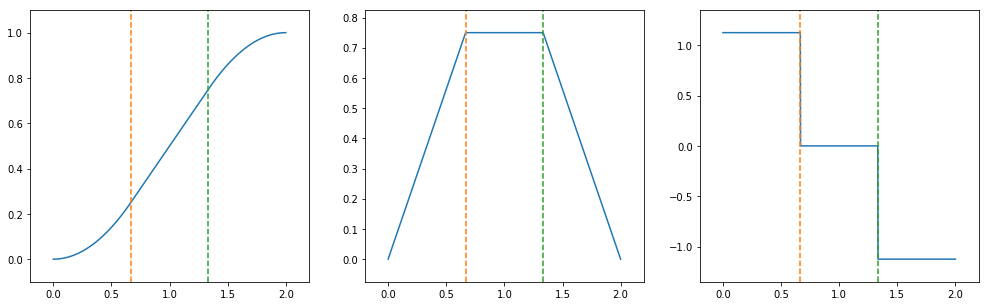

In [3]:
ts, q1, q̇1, q̈1 = grafica_trayectoria(0, 2, 0, 1, 1001)

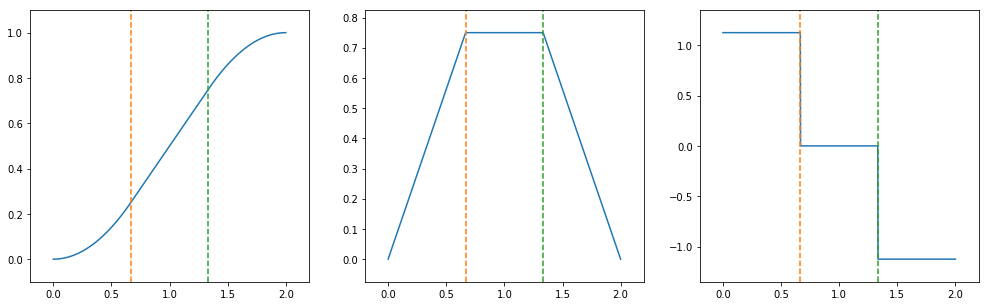

In [4]:
ts, q2, q̇2, q̈2 = grafica_trayectoria(0, 2, 0, 1, 1001)

In [5]:
estado_deseado = q1, q2, q̇1, q̇2, q̈1, q̈2
tiempos = ts.tolist()
#int(tiempos[-1]*500)
tiempos[-1]

2.0

In [19]:
from scipy.integrate import odeint
from numpy import linspace, interp, array

In [20]:
def control_pd_compensacion(estado, tiempo):
    
    from numpy import sin, cos
    q1, q2, q̇1, q̇2 = estado
    qd1, qd2, q̇d1, q̇d2, q̈d1, q̈d2 = estado_deseado
    i = int(tiempo*500)
    a, b = interp(tiempo, ts, qd1), interp(tiempo, ts, qd2)
    c, d = interp(tiempo, ts, q̇d1), interp(tiempo, ts, q̇d2)
    g = 9.81
    m1, m2 = 1, 1
    L1, L2 = 1, 1
    l1, l2 = 0.5*L1, 0.5*L2
    
    kp1, kp2 = 200, 200
    kv1, kv2 = 20, 20
    
    τ1 = kp1*(a - q1) + kv1*(c - q̇1) + g*(m1*l1*cos(q1) + m2*L1*cos(q1) + m2*l2*cos(q1+q2))
    τ2 = kp2*(b - q2) + kv2*(d - q̇2) + g*m2*l2*cos(q1+q2)
    
    return τ1, τ2

def control_par_calculado(estado, tiempo):
    
    from numpy import sin, cos
    q1, q2, q̇1, q̇2 = estado
    qd1, qd2, q̇d1, q̇d2, q̈d1, q̈d2 = estado_deseado
    i = int(tiempo*500)
    a, b = interp(tiempo, ts, qd1), interp(tiempo, ts, qd2)
    c, d = interp(tiempo, ts, q̇d1), interp(tiempo, ts, q̇d2)
    e, f = interp(tiempo, ts, q̈d1), interp(tiempo, ts, q̈d2)
    g = 9.81
    m1, m2 = 1, 1
    L1, L2 = 1, 1
    l1, l2 = 0.5*L1, 0.5*L2
    J1, J2 = 0.01, 0.01
    
    # Se calculan algunos terminos comunes
    μ1 = m2*l2**2
    μ2 = m2*L1*l2
    c1, c2, s2 = cos(q1), cos(q2), sin(q2)
    c12, s12 = cos(q1 + q2), sin(q1 + q2)
    
    kp1, kp2 = 50, 200
    kv1, kv2 = 2, 2
    
    v1 = kp1*(a - q1) + kv1*(c - q̇1) + e
    v2 = kp2*(b - q2) + kv2*(d - q̇2) + f
    M1 = (m1*l1**2 + m2*L1**2 + μ1 + 2*μ2*c2 + J1 + J2)*v1 + (μ1 + μ2*c2 + J2)*v2
    M2 = (μ1 + μ2*c2 + J2)*v1 + (μ1 + J2)*v2
    C1 = -μ2*s2*(q̇1*q̇2 + q̇2**2)
    C2 = μ2*s2*q̇1**2
    G1 = g*(m1*l1*c1 + m2*L1*c1 + m2*l2*c12)
    G2 = g*m2*l2*c12
    
    τ1 = M1 + C1 + G1
    τ2 = M2 + C2 + G2
    
    return τ1, τ2

def señales(tiempo, q1, q2, q̇1, q̇2, ts):
    i = ts.index(tiempo)
    return q1[i], q2[i], q̇1[i], q̇2[i]

In [21]:
def pendulo_doble(estado, tiempo):
    # Se importan funciones necesarias
    from numpy import sin, cos, matrix
    
    # Se desenvuelven variables del estado y tiempo
    q1, q2, q̇1, q̇2 = estado
    t = tiempo
    
    # Se declaran constantes del sistema
    m1, m2 = 1, 1
    L1, L2 = 1, 1
    l1, l2 = 0.5*L1, 0.5*L2
    J1, J2 = 0.01, 0.01
    g = 9.81
        
    # Se calculan algunos terminos comunes
    μ1 = m2*l2**2
    μ2 = m2*L1*l2
    c1, c2, s2 = cos(q1), cos(q2), sin(q2)
    c12, s12 = cos(q1 + q2), sin(q1 + q2)
    
    # Se declaran señales de control del sistema
    tau1, tau2 = control_par_calculado(estado, tiempo)
    
    # Se calculan las matrices de masas, Coriolis,
    # y vectores de gravedad, control, posicion y velocidad
    M = matrix([[m1*l1**2 + m2*L1**2 + μ1 + 2*μ2*c2 + J1 + J2, μ1 + μ2*cos(q2) + J2],
                [μ1 + μ2*cos(q2) + J2, μ1 + J2]])
    C = -μ2*s2*matrix([[q̇2, q̇2],
                       [q̇1, 0]])
    G = g*matrix([[m1*l1*c1 + m2*L1*c1 + m2*l2*c12],
                  [m2*l2*c12]])
    Tau = matrix([[tau1], [tau2]])
    q = matrix([[q1], [q2]])
    q̇ = matrix([[q̇1], [q̇2]])
    
    # Se calcula la derivada del estado del sistema
    qp1 = q̇1
    qp2 = q̇2
    
    qpp = M.I*(Tau - C*q̇ - G)
    qpp1, qpp2 = qpp.tolist()
    
    return [qp1, qp2, qpp1[0], qpp2[0]]

In [22]:
estados_simulados = odeint(func = pendulo_doble, y0 = [0, 0, 0, 0], t = ts)

In [23]:
a, b, c, d = list(zip(*estados_simulados.tolist()))

In [24]:
%matplotlib inline
from matplotlib.pyplot import subplots

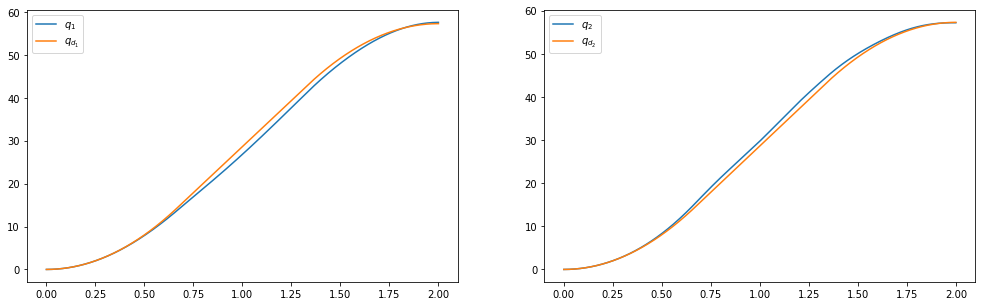

In [25]:
fig, axes = subplots(nrows=1, ncols=2, figsize=(17, 5))

p1, = axes[0].plot(ts, array(a)*180/pi)
p2, = axes[1].plot(ts, array(b)*180/pi)

p3, = axes[0].plot(ts, array(q1)*180/pi)
p4, = axes[1].plot(ts, array(q2)*180/pi)

axes[0].legend([p1, p3],[r"$q_1$", r"$q_{d_1}$"])
axes[1].legend([p2, p4],[r"$q_2$", r"$q_{d_2}$"])
#ax1.set_ylim(-4, 4)
axes[0].set_xlim(-0.1, 2.1)
axes[1].set_xlim(-0.1, 2.1);

In [26]:
from numpy import array, pi

In [27]:
e1, e2 = 180/pi*(array(a) - array(q1)), 180/pi*(array(b) - array(q2))

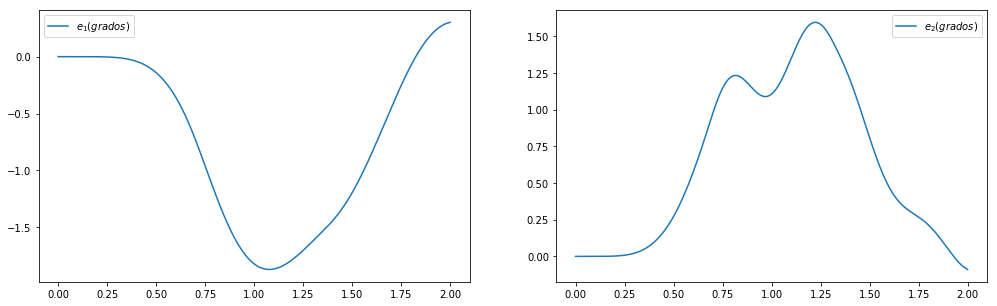

In [28]:
fig, axes = subplots(nrows=1, ncols=2, figsize=(17, 5))

p1, = axes[0].plot(ts, e1)
p2, = axes[1].plot(ts, e2)

axes[0].legend([p1],[r"$e_1 (grados)$"])
axes[1].legend([p2],[r"$e_2 (grados)$"])
#ax1.set_ylim(-4, 4)
axes[0].set_xlim(-0.1, 2.1)
axes[1].set_xlim(-0.1, 2.1);

In [29]:
us = [control_par_calculado([q1, q2, q̇1, q̇2], 0) for (q1, q2, q̇1, q̇2) in estados_simulados]

In [30]:
u1, u2 = zip(*us)

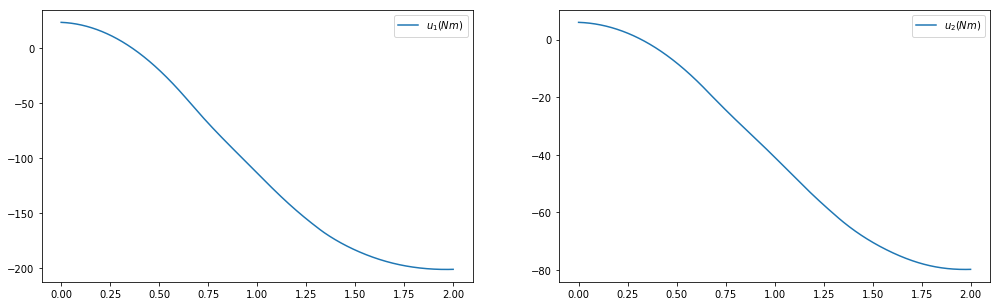

In [31]:
fig, axes = subplots(nrows=1, ncols=2, figsize=(17, 5))

p1, = axes[0].plot(ts, u1)
p2, = axes[1].plot(ts, u2)

axes[0].legend([p1],[r"$u_1 (Nm)$"])
axes[1].legend([p2],[r"$u_2 (Nm)$"])
#ax1.set_ylim(-4, 4)
axes[0].set_xlim(-0.1, 2.1)
axes[1].set_xlim(-0.1, 2.1);

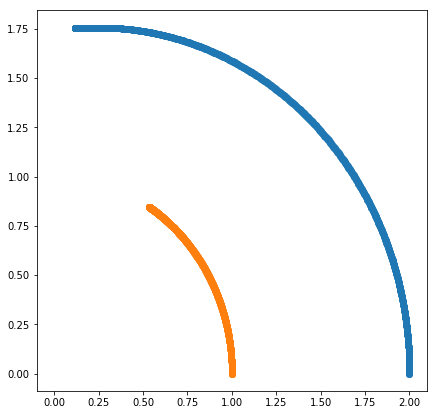

In [32]:
from numpy import sin, cos
x1s = [1*cos(q1) for (q1, q2) in zip(a, b)]
y1s = [1*sin(q1) for (q1, q2) in zip(a, b)]
x2s = [1*cos(q1) + 1*cos(q1+q2) for (q1, q2) in zip(a, b)]
y2s = [1*sin(q1) + 1*sin(q1+q2) for (q1, q2) in zip(a, b)]
fig, axes = subplots(nrows=1, ncols=1, figsize=(7, 7))

p1, = axes.plot(x2s, y2s, "o")
axes.plot(x1s, y1s, "o")

#axes[0].legend([p1, p3],[r"$q_1$", r"$q_{d_1}$"])
#axes[1].legend([p2, p4],[r"$q_2$", r"$q_{d_2}$"])
#ax1.set_ylim(-4, 4)
axes.set_xlim(-0.1, 2.1);